In [1]:
import torch
import numpy as np

def average_cosine(vectors):
    # Normalize each vector
    vectors_norm = vectors / vectors.norm(dim=1, keepdim=True)

    # Compute the cosine similarity matrix (dot product of normalized vectors)
    cosine_similarities = vectors_norm @ vectors_norm.T

    # Extract the upper triangle of the matrix, excluding the diagonal
    num_objects = vectors.shape[0]
    i, j = torch.triu_indices(num_objects, num_objects, offset=1)
    cosine_similarities_upper = cosine_similarities[i, j]
    # Calculate the average cosine similarity
    average_cosine = cosine_similarities_upper.mean().item()
    return average_cosine


def average_conditional_probability(vectors):
    num_objects, dim = vectors.shape
    total_prob = 0.0
    count_nonzero_dimensions = 0

    for d in range(dim):
        dimension_values = vectors[:, d]
        if dimension_values.sum() >= 1:
            count_nonzero_dimensions += 1
            prob = (dimension_values.sum() - 1) / (num_objects - 1)
            total_prob += prob
    average_prob = total_prob / count_nonzero_dimensions if count_nonzero_dimensions > 0 else 0.0
    return average_prob

def average_pair_response_probability(vectors):
    num_objects, dim = vectors.shape
    total_prob = 0.0
    count_active_neurons = 0

    # Loop over each neuron (dimension)
    for d in range(dim):
        k = int(vectors[:, d].sum())
        if k >= 1:
            count_active_neurons += 1
            # If a neuron fires for only one object, its pair response probability is 0.
            prob = (k * (k - 1)) / (num_objects * (num_objects - 1))
            total_prob += prob

    average_prob = total_prob / count_active_neurons if count_active_neurons > 0 else 0.0
    return average_prob

def average_pair_response_ratio(vectors):
    num_objects, dim = vectors.shape
    total_ratio = 0.0
    count_pairs = 0

    # Loop over each pair of items
    for i in range(num_objects):
        for j in range(i + 1, num_objects):
            # For the two items, determine which neurons fire for both:
            both = (vectors[i] * vectors[j]).sum()
            # Determine which neurons fire for at least one of the two items:
            union = ((vectors[i] + vectors[j]) > 0).sum()
            if union > 0:
                ratio = both / union
                total_ratio += ratio
                count_pairs += 1

    average_ratio = total_ratio / count_pairs if count_pairs > 0 else 0.0
    return average_ratio


def gen_W(num_objects, dim, target_cosine):
    # Define ranges
    sparsity_range = (0.002, 0.01)
    # Initialize the vectors tensor with random sparsity
    vectors = torch.zeros((num_objects, dim), dtype=torch.float)
    num_ones = torch.randint(int(sparsity_range[0] * dim), int(sparsity_range[1] * dim + 1), (num_objects,))
    for i in range(num_objects):
        ones_indices = torch.randperm(dim)[:num_ones[i]]
        vectors[i, ones_indices] = 1

    cos = average_cosine(vectors)
#     p = average_conditional_probability(vectors)
#     p = average_pair_response_probability(vectors)
    p = average_pair_response_ratio(vectors)
    count = 0
    while(cos<target_cosine):
        if count>1000:
            break
        count+=1
        # Randomly pick a pair of objects i and j
        indices = torch.randperm(num_objects)[:2]
        i, j = indices[0], indices[1]
        vi = vectors[i, :]
        vj = vectors[j, :]

        # Identify dimensions where only one of them has a 1 using XOR
        diff_indices = torch.nonzero(vi.int() ^ vj.int()).flatten()
        if len(diff_indices) > 0:
            # Randomly pick one such dimension
            dim_to_change = diff_indices[torch.randint(len(diff_indices), (1,)).item()]
        else:
            continue

        # Determine which vector has 0 at the chosen dimension
        if vi[dim_to_change] == 0:
            index_to_modify = i
        else:
            index_to_modify = j

        # Set the value of this object at the chosen dimension to 1
        vectors[index_to_modify, dim_to_change] = 1

        # Find a dimension in the same object that currently equals 1
        ones_indices = torch.nonzero(vectors[index_to_modify] == 1).flatten()
        ones_indices = ones_indices[ones_indices != dim_to_change]  # Exclude the modified dimension

        # Randomly pick one such dimension to set to 0
        dim_to_zero = ones_indices[torch.randint(len(ones_indices), (1,)).item()]
        vectors[index_to_modify, dim_to_zero] = 0

        # Compute the average cosine again
        cos = average_cosine(vectors)
#     p = average_conditional_probability(vectors)
#     p = average_pair_response_probability(vectors)
    p = average_pair_response_ratio(vectors)
#     print(f'p:{p}, cos: {cos}')
    return p, cos

In [2]:
from tqdm.notebook import tqdm

targets = np.logspace(-2, -0.0, num=50, endpoint=False)
p_all = []
cos_all = []
num_objects = 10
dim = 1000
for repeats in tqdm(range(10), desc='repreat'):
    for overlap_low in targets:
        p, cos = gen_W(num_objects, dim, overlap_low)
        if cos <=0.5 and p<0.3:
            p_all += [p]
            cos_all += [cos]

repreat:   0%|          | 0/10 [00:00<?, ?it/s]

# Supplementary Figure S1A

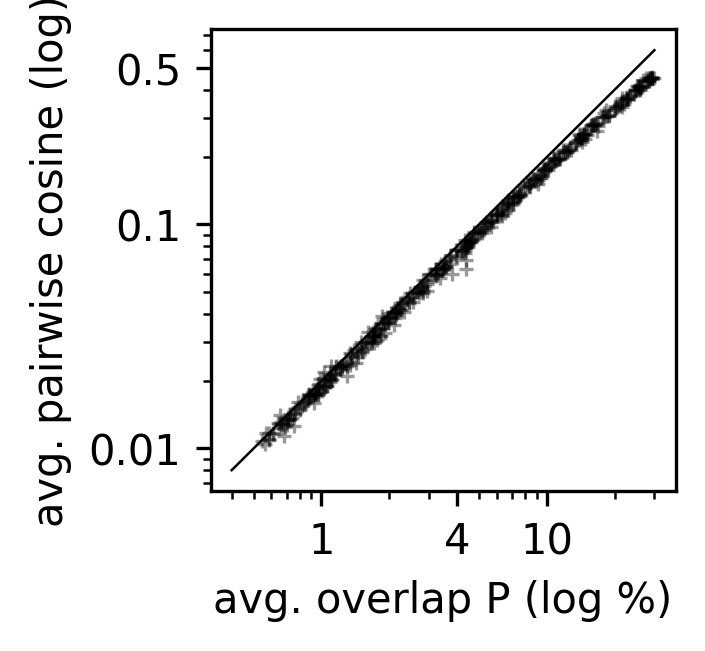

In [3]:
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt


def custom_format(x, pos):
    return f"{x:g}"

# Switch x and y axes
plt.figure(figsize=(2, 2), dpi=300)
plt.scatter(np.array(p_all) * 100, cos_all, marker='+', c='black', alpha=0.4, s=10, linewidths=0.8)
plt.xlabel('avg. overlap P (log %)')
plt.ylabel('avg. pairwise cosine (log)')

plt.xscale('log')
plt.yscale('log')

plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.xticks([0.1, 1, 4, 10, 40], [custom_format(tick, None) for tick in [0.1, 1, 4, 10, 40]])
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.yticks([0.01, 0.10, 0.50], [custom_format(tick, None) for tick in [0.01, 0.1, 0.5]])

# Plot the line with swapped axes
x = np.arange(0.4, 30, 0.01)  # Overlap values
y = x / 50  # Corresponding cosine values
plt.plot(x, y, c='black', lw=0.6)

# plt.text(0.5, 0.4, 'y = x / 50', fontsize=8)
plt.show()


In [4]:
import torch
import numpy as np

def average_cosine(vectors):

    # Normalize each vector
    vectors_norm = vectors / vectors.norm(dim=1, keepdim=True)

    # Compute the cosine similarity matrix (dot product of normalized vectors)
    cosine_similarities = vectors_norm @ vectors_norm.T

    # Extract the upper triangle of the matrix, excluding the diagonal
    num_objects = vectors.shape[0]
    i, j = torch.triu_indices(num_objects, num_objects, offset=1)
    cosine_similarities_upper = cosine_similarities[i, j]
    # Calculate the average cosine similarity
    average_cosine = cosine_similarities_upper.mean().item()

    
    return average_cosine


def gen_W(num_objects, dim, target_cosine):
    # Define ranges
    sparsity_range = (0.002, 0.01)
    # Initialize the vectors tensor with random sparsity
    vectors = torch.zeros((num_objects, dim), dtype=torch.float)
    num_ones = torch.randint(int(sparsity_range[0] * dim), int(sparsity_range[1] * dim + 1), (num_objects,))
    for i in range(num_objects):
        ones_indices = torch.randperm(dim)[:num_ones[i]]
        vectors[i, ones_indices] = 1

    cos = average_cosine(vectors)
    if target_cosine==0 and cos!=0:
        vectors = torch.zeros((num_objects, dim), dtype=torch.float)
        num_ones = torch.randint(int(sparsity_range[0] * dim), int(sparsity_range[1] * dim + 1), (num_objects,))
        for i in range(num_objects):
            ones_indices = torch.randperm(dim)[:num_ones[i]]
            vectors[i, ones_indices] = 1

        cos = average_cosine(vectors)
        

    while(cos<target_cosine):
        # Randomly pick a pair of objects i and j
        indices = torch.randperm(num_objects)[:2]
        i, j = indices[0], indices[1]
        vi = vectors[i, :]
        vj = vectors[j, :]

        # Identify dimensions where only one of them has a 1 using XOR
        diff_indices = torch.nonzero(vi.int() ^ vj.int()).flatten()
        if len(diff_indices) > 0:
            # Randomly pick one such dimension
            dim_to_change = diff_indices[torch.randint(len(diff_indices), (1,)).item()]
        else:
            continue

        # Determine which vector has 0 at the chosen dimension
        if vi[dim_to_change] == 0:
            index_to_modify = i
        else:
            index_to_modify = j

        # Set the value of this object at the chosen dimension to 1
        vectors[index_to_modify, dim_to_change] = 1

        # Find a dimension in the same object that currently equals 1
        ones_indices = torch.nonzero(vectors[index_to_modify] == 1).flatten()
        ones_indices = ones_indices[ones_indices != dim_to_change]  # Exclude the modified dimension

        # Randomly pick one such dimension to set to 0
        dim_to_zero = ones_indices[torch.randint(len(ones_indices), (1,)).item()]
        vectors[index_to_modify, dim_to_zero] = 0

        # Compute the average cosine again
        cos = average_cosine(vectors)
#     print(cos)
    return vectors.T



In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import torch
import numpy as np
from tqdm.notebook import tqdm

# Set parameters
num_objects = 10
input_dim = num_objects
hidden_dim = 10000
output_dim = 1

# Ground truth ranking
ground_truth_ranking = list(range(num_objects))

# Create all possible pairs and labels
test_pairs = [(i, j) for i in range(num_objects) for j in range(num_objects) if ((i != j) and (i-j!=1) and (j-i!=1))]
test_labels = [1 if ground_truth_ranking.index(i) < ground_truth_ranking.index(j) else -1 for i, j in test_pairs]

train_pairs = [(i, i+1) for i in range(num_objects-1)]
train_labels = [1 for i, j in train_pairs]

# One-hot encode the input
one_hot_vectors = torch.eye(num_objects)

# Split into training and testing datasets


# Initialize results storage
all_accuracies = []
all_accuracies2 = []
all_accuracies_w = []
all_accuracies_w2 = []
all_mean_values = []
# Repeat the experiment
for repeat in tqdm(range(100), desc="Repeats"):
    print(repeat)
    # Initialize weights for both cases
    W1 = gen_W(num_objects, hidden_dim, 0)
    W2 = gen_W(num_objects, hidden_dim, 0.1)
    P1 = torch.randn(output_dim, hidden_dim) * 0.0001
    P2 = torch.randn(output_dim, hidden_dim) * 0.0001
    allcorrect1 = False
    allcorrect2 = False
    # Learning rate
    eta = 0.01

    # Training parameters
    total_iterations = 400

    accuracies1 = []
    accuracies2 = []
    
    accuracies_w1 = []
    accuracies_w2 = []
    
    mean_v_values = np.zeros((total_iterations, num_objects))
    mean_v_values2 = np.zeros((total_iterations, num_objects))

    # Training loop
    for iteration in range(total_iterations):
        # Randomly pick a sample from the training set
        idx = np.random.randint(0, len(train_pairs))
        (i, j), label = train_pairs[idx], train_labels[idx]

        # Case 1: Training with W1
        s_i1 = W1 @ one_hot_vectors[i]
        s_j1 = W1 @ one_hot_vectors[j]
        v_i1 = P1 @ s_i1
        v_j1 = P1 @ s_j1

        error1 = torch.sign(torch.maximum((label * (v_i1 - v_j1) +1), torch.tensor(0))*label)

#         break
        e_vec1 = error1 
#         print(e_vec1)

        with torch.no_grad():
            if not allcorrect1:
                P1 += eta * torch.outer(e_vec1, s_j1 - s_i1)

        # Case 2: Training with W2
        s_i2 = W2 @ one_hot_vectors[i]
        s_j2 = W2 @ one_hot_vectors[j]
        v_i2 = P2 @ s_i2
        v_j2 = P2 @ s_j2

        error2 = torch.sign(torch.maximum((label * (v_i2 - v_j2) +1), torch.tensor(0))*label)
        e_vec2 = error2

        with torch.no_grad():
            if not allcorrect2:
                P2 += eta * torch.outer(e_vec2, s_j2 - s_i2)
        for i in range(num_objects):
            s1 = W1 @ one_hot_vectors[i]
            v1 = P1 @ s1
            s2 = W2 @ one_hot_vectors[i]
            v2 = P2 @ s2
            mean_v_values[iteration, i] = v1.mean().item()
            mean_v_values2[iteration, i] = v2.mean().item()
            
        summed_v_values = mean_v_values[iteration, :]
        learned_ranking = sorted(range(num_objects), key=lambda i: summed_v_values[i])
        if learned_ranking == list(ground_truth_ranking):
            if allcorrect1 == False:
                print('ortho:', iteration, len(accuracies_w1))
            allcorrect1 = True
            
            
            
        summed_v_values2 = mean_v_values2[iteration, :]
        learned_ranking2 = sorted(range(num_objects), key=lambda i: summed_v_values2[i])
        if learned_ranking2 == list(ground_truth_ranking):
            if allcorrect2 == False:
                print('0.1:', iteration, len(accuracies_w2))
            allcorrect2 = True
            
            

        # Evaluate on the test set
        if iteration % 1 == 0:  # Test every iteration
            correct1 = 0
            correct2 = 0

            for (i_test, j_test), label_test in zip(test_pairs, test_labels):
                # Case 1: Testing with W1
                s_i_test1 = W1 @ one_hot_vectors[i_test]
                s_j_test1 = W1 @ one_hot_vectors[j_test]
                v_i_test1 = P1 @ s_i_test1
                v_j_test1 = P1 @ s_j_test1
                prediction1 = 1 if v_i_test1.mean() < v_j_test1.mean() else -1
                correct1 += (prediction1 == label_test)

                # Case 2: Testing with W2
                s_i_test2 = W2 @ one_hot_vectors[i_test]
                s_j_test2 = W2 @ one_hot_vectors[j_test]
                v_i_test2 = P2 @ s_i_test2
                v_j_test2 = P2 @ s_j_test2
                prediction2 = 1 if v_i_test2.mean() < v_j_test2.mean() else -1
                correct2 += (prediction2 == label_test)

            # Calculate accuracies
            accuracy1 = correct1 / len(test_pairs)
            accuracy2 = correct2 / len(test_pairs)
            accuracies1.append(accuracy1)
            accuracies2.append(accuracy2)
            if error1 != 0:
                accuracies_w1.append(accuracy1)
            if error2 != 0:
                accuracies_w2.append(accuracy2)
                
    all_mean_values.append(mean_v_values[-1,:])
    all_accuracies.append(accuracies1)
    all_accuracies2.append(accuracies2)
    accuracies_w1_complete = np.ones(total_iterations)
    accuracies_w2_complete = np.ones(total_iterations)
    accuracies_w1_complete[:len(accuracies_w1)] = np.array(accuracies_w1)
    accuracies_w2_complete[:len(accuracies_w2)] = np.array(accuracies_w2)
    all_accuracies_w.append(accuracies_w1_complete)
    all_accuracies_w2.append(accuracies_w2_complete)



Repeats:   0%|          | 0/100 [00:00<?, ?it/s]

0
ortho: 185 104
0.1: 187 109
1
0.1: 271 164
ortho: 280 162
2
ortho: 169 99
0.1: 273 165
3
0.1: 164 95
ortho: 306 158
4
0.1: 190 108
ortho: 203 122
5
ortho: 184 104
0.1: 224 123
6
0.1: 204 112
ortho: 205 90
7
ortho: 189 121
0.1: 208 141
8
0.1: 257 130
ortho: 291 159
9
0.1: 244 112
ortho: 302 134
10
ortho: 170 100
0.1: 211 123
11
ortho: 241 142
0.1: 244 150
12
ortho: 279 158
0.1: 332 180
13
ortho: 220 114
0.1: 220 121
14
ortho: 134 85
0.1: 184 115
15
ortho: 137 84
0.1: 210 121
16
0.1: 164 102
ortho: 177 113
17
0.1: 140 86
ortho: 155 97
18
ortho: 152 93
0.1: 308 174
19
ortho: 234 116
0.1: 280 161
20
0.1: 251 134
21
ortho: 265 140
0.1: 292 164
22
ortho: 155 102
0.1: 195 119
23
0.1: 165 109
ortho: 239 131
24
ortho: 154 90
0.1: 201 118
25
ortho: 237 123
0.1: 240 131
26
0.1: 190 129
ortho: 250 153
27
0.1: 193 119
ortho: 224 126
28
0.1: 189 104
ortho: 190 101
29
ortho: 247 136
0.1: 323 167
30
ortho: 254 113
0.1: 277 135
31
0.1: 238 135
ortho: 252 139
32
ortho: 237 116
0.1: 257 126
33
ortho: 1

# Figure 2D

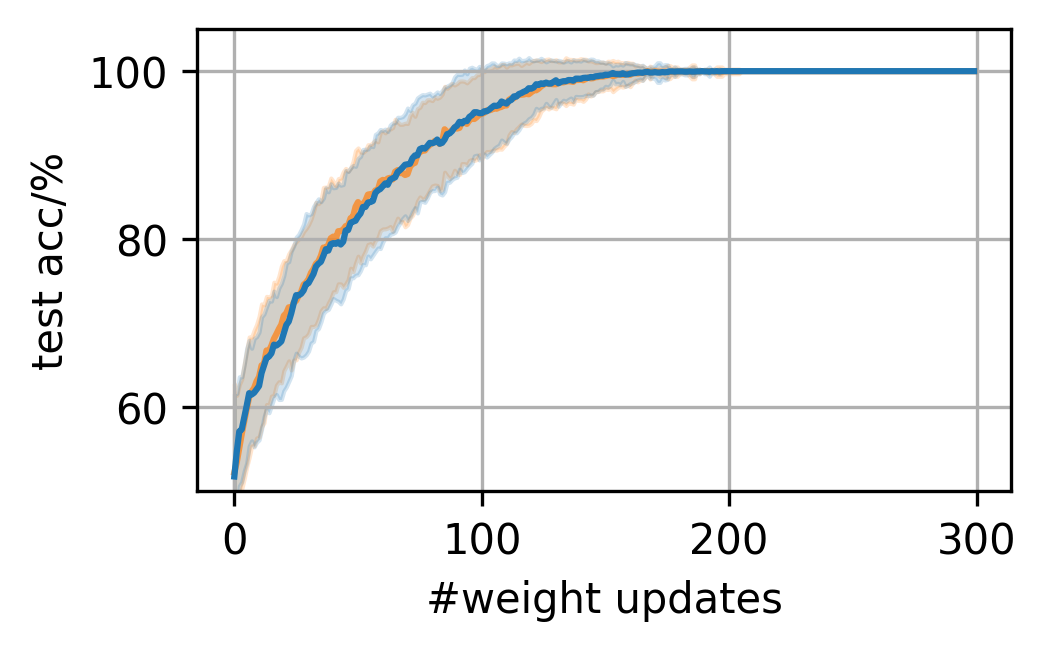

In [6]:
import matplotlib.pyplot as plt
data_array = np.array(all_accuracies_w)[:,:300]*100

# Calculate mean and standard deviation across the data
mean_values = np.mean(data_array, axis=0)
std_values = np.std(data_array, axis=0)

# Create an array for the iteration indices
iterations = np.arange(data_array.shape[1])

# Plot mean with shaded standard deviation
plt.figure(figsize=(3.5, 2), dpi=300)

data_array2 = np.array(all_accuracies_w2)[:,:300]*100

# Calculate mean and standard deviation across the data
mean_values2 = np.mean(data_array2, axis=0)
std_values2 = np.std(data_array2, axis=0)



# Create an array for the iteration indices
iterations = np.arange(data_array2.shape[1])

# Plot mean with shaded standard deviation
plt.fill_between(iterations, mean_values2 - std_values2, mean_values2 + std_values2, color="tab:orange", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values2, label="Mean Correlation", color="tab:orange", alpha=0.7)

plt.fill_between(iterations, mean_values - std_values, mean_values + std_values, color="tab:blue", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values, label="Mean Correlation", color="tab:blue")

# epochs = iterations / 90
# plt.xticks(ticks=iterations[::90].tolist()+[450], labels=np.arange(6).astype(np.int8))
plt.ylim(50,105)
plt.xticks(np.arange(0,301,100))
# Add labels and title
# plt.title("Correlation Change Across Training Iterations")
plt.xlabel("#weight updates")
plt.ylabel("test acc/%")
# plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Figure 2E

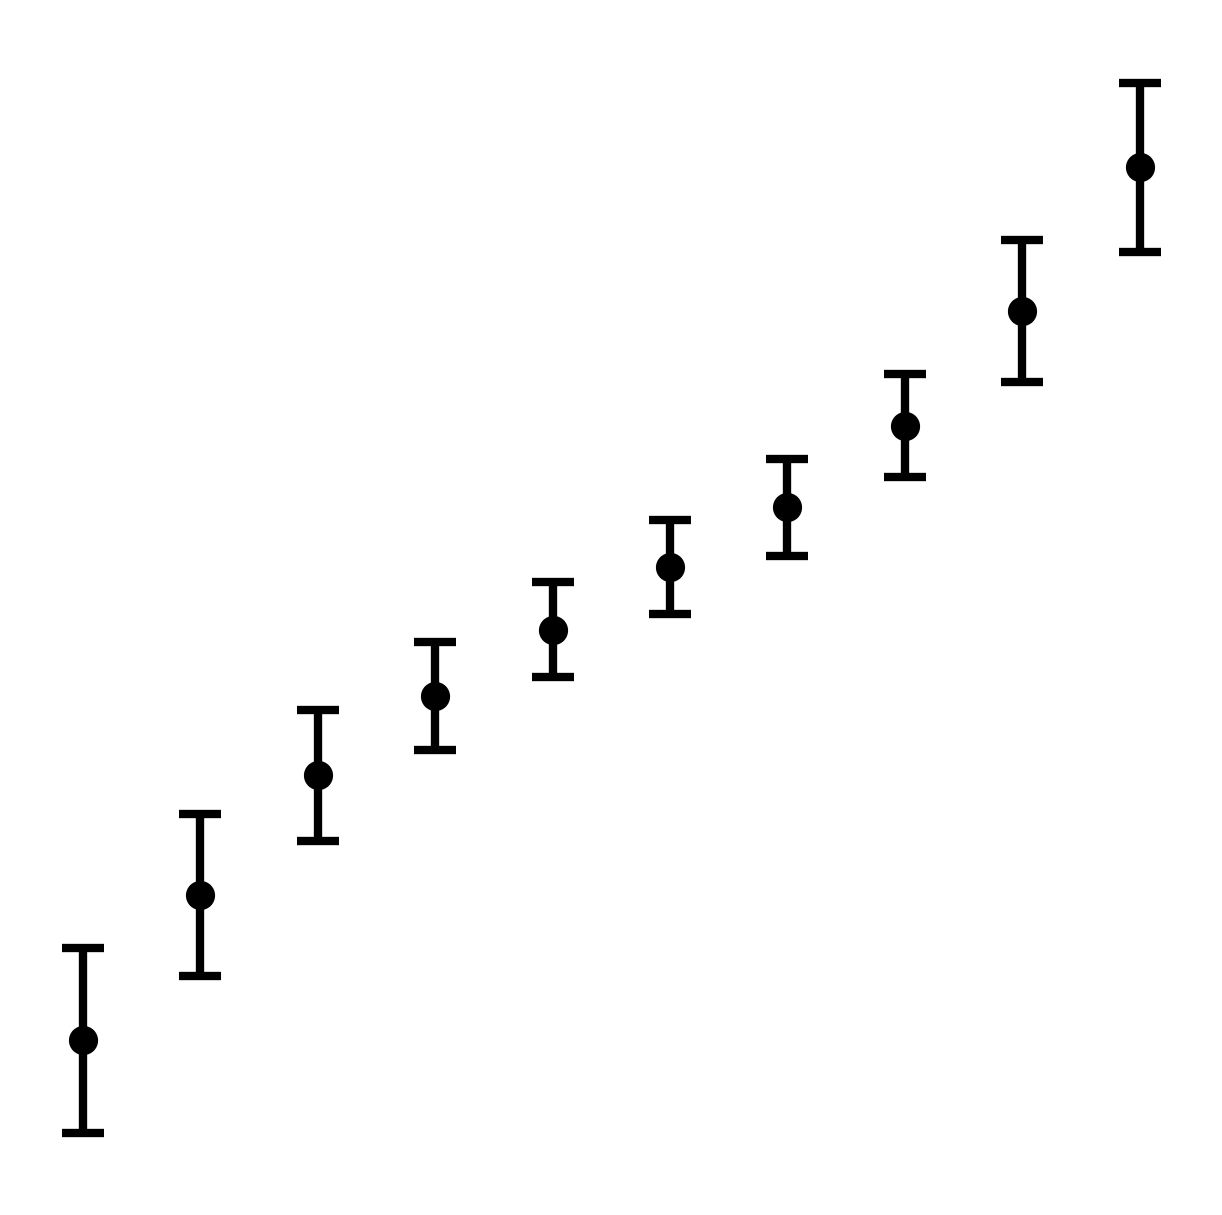

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Example data

# Calculate mean and standard deviation across the samples
mean_values = np.array(all_mean_values).mean(axis=0)
std_values = np.array(all_mean_values).std(axis=0)

plt.figure(figsize=(5, 5), dpi=300)

# Plot the scatter points with error bars
plt.errorbar(
    range(10),              # x-values
    mean_values,            # y-values (means)
    yerr=std_values,        # error values (e.g., standard deviation)
    fmt='.',                # marker style (using 'x')
    color='black',          # color of markers and error bars
    capsize=5,              # size of the error bar caps
    markersize=10,          # size of the marker
    elinewidth=2,           # width of the error bar lines
    markeredgewidth=2       # width of the marker edges
)

# Optionally, plot a reference line (as in your code)
# plt.plot(range(10), np.arange(10) - 4.25, '--', c='black', alpha=.6)

plt.axis('off')
plt.show()


# Figure S2

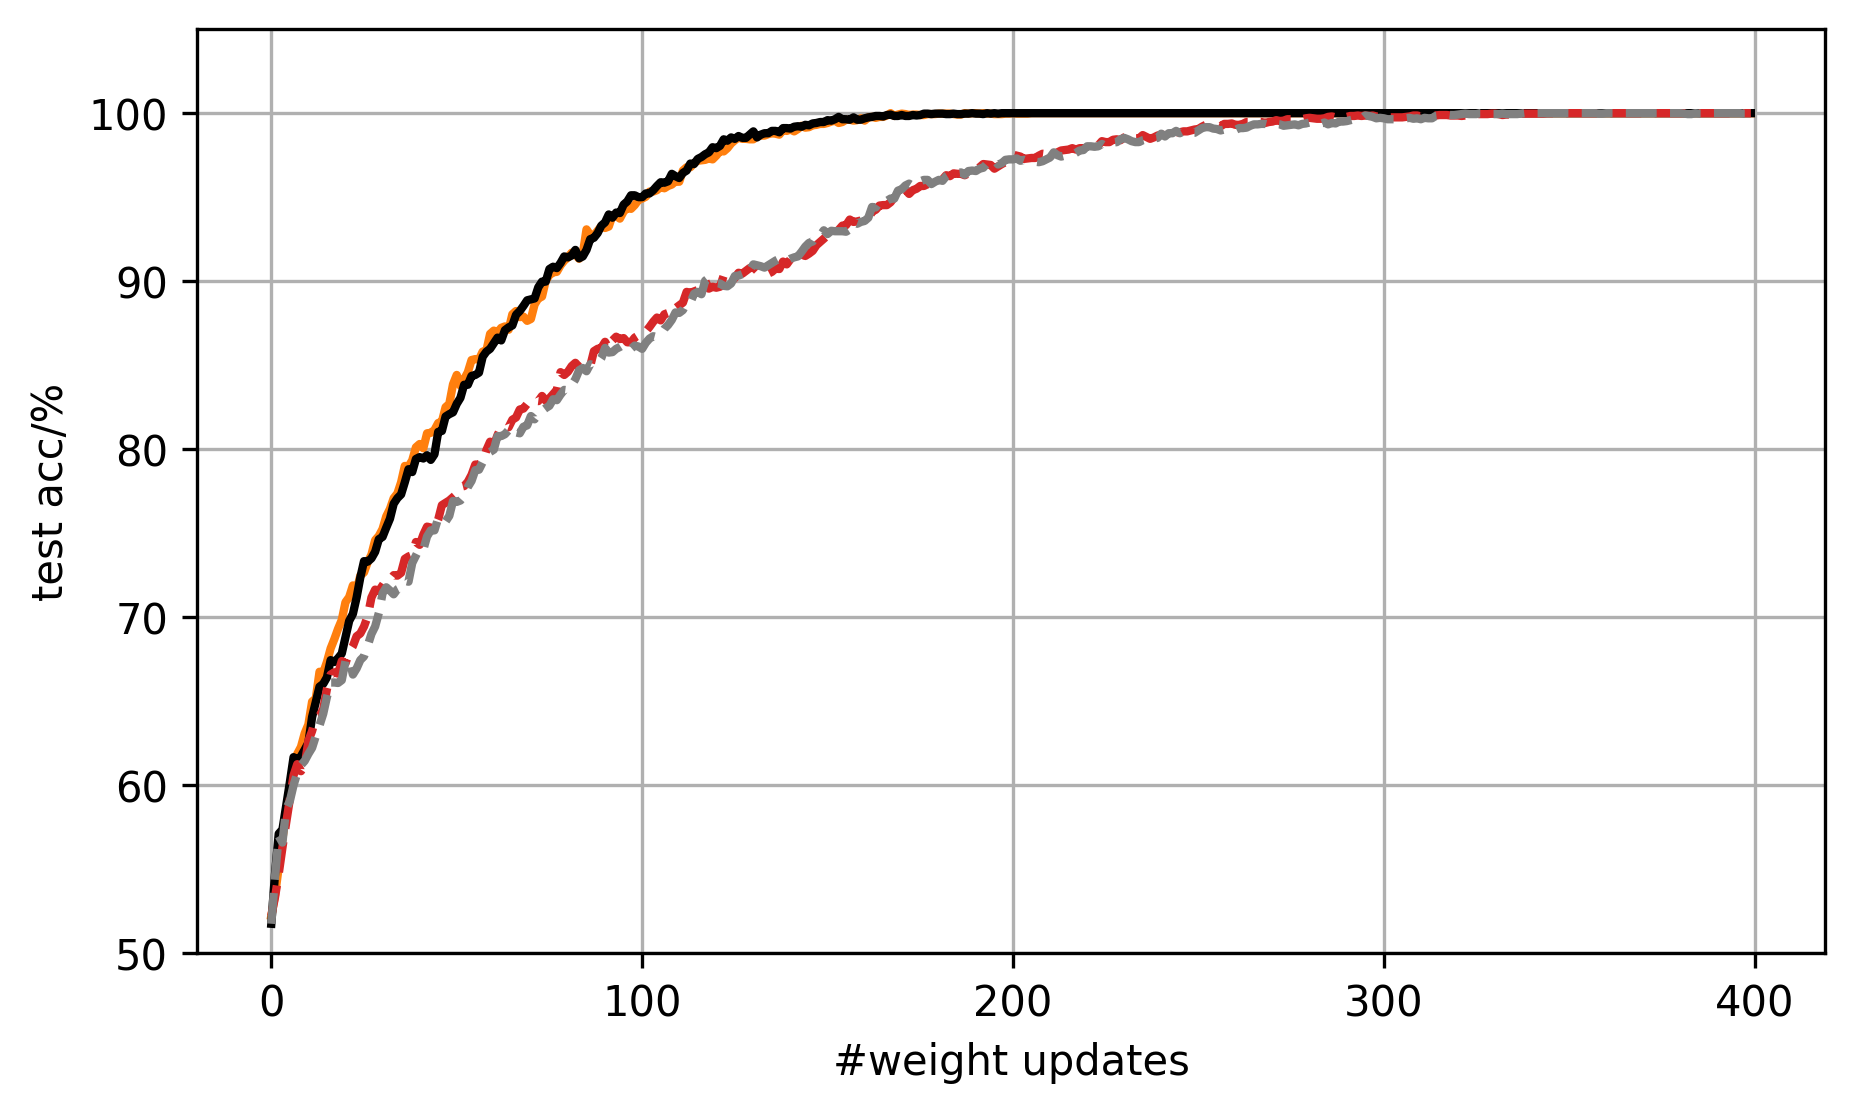

In [8]:
import matplotlib.pyplot as plt
data_array = np.array(all_accuracies)*100
data_array_w = np.array(all_accuracies_w)*100
# Calculate mean and standard deviation across the data
mean_values = np.mean(data_array, axis=0)
std_values = np.std(data_array, axis=0)
mean_values_w = np.mean(data_array_w, axis=0)
std_values_w = np.std(data_array_w, axis=0)

# Create an array for the iteration indices
iterations = np.arange(data_array.shape[1])

# Plot mean with shaded standard deviation
plt.figure(figsize=(3.5*2, 2*2), dpi=300)
data_array2 = np.array(all_accuracies2)*100
data_array_w2 = np.array(all_accuracies_w2)*100

# Calculate mean and standard deviation across the data
mean_values2 = np.mean(data_array2, axis=0)
std_values2 = np.std(data_array2, axis=0)
mean_values_w2 = np.mean(data_array_w2, axis=0)
std_values_w2 = np.std(data_array_w2, axis=0)


# Create an array for the iteration indices
iterations = np.arange(data_array2.shape[1])

# Plot mean with shaded standard deviation


# plt.fill_between(iterations, mean_values_w2 - std_values_w2, mean_values_w2 + std_values_w2, color="tab:orange", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values_w2, label="Mean Correlation", color="tab:orange", linewidth=2)



# plt.fill_between(iterations, mean_values_w - std_values_w, mean_values_w + std_values_w, color="black", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values_w, label="Mean Correlation", color="black", linewidth=2)

# plt.fill_between(iterations, mean_values2 - std_values2, mean_values2 + std_values2, color="tab:red", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values2, linestyle='dashed', label="Mean Correlation", color="tab:red", linewidth=2)

# plt.fill_between(iterations, mean_values - std_values, mean_values + std_values, color="gray", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values, linestyle='dashed', label="Mean Correlation", color="gray", linewidth=2)

# epochs = iterations / 90
# plt.xticks(ticks=iterations[::90].tolist()+[450], labels=np.arange(6).astype(np.int8))
plt.ylim(50,105)
plt.xticks(np.arange(0,401,100))
# Add labels and title
# plt.title("Correlation Change Across Training Iterations")
plt.xlabel("#weight updates")
plt.ylabel("test acc/%")
# plt.legend()
plt.grid(True)

# Show the plot
plt.show()

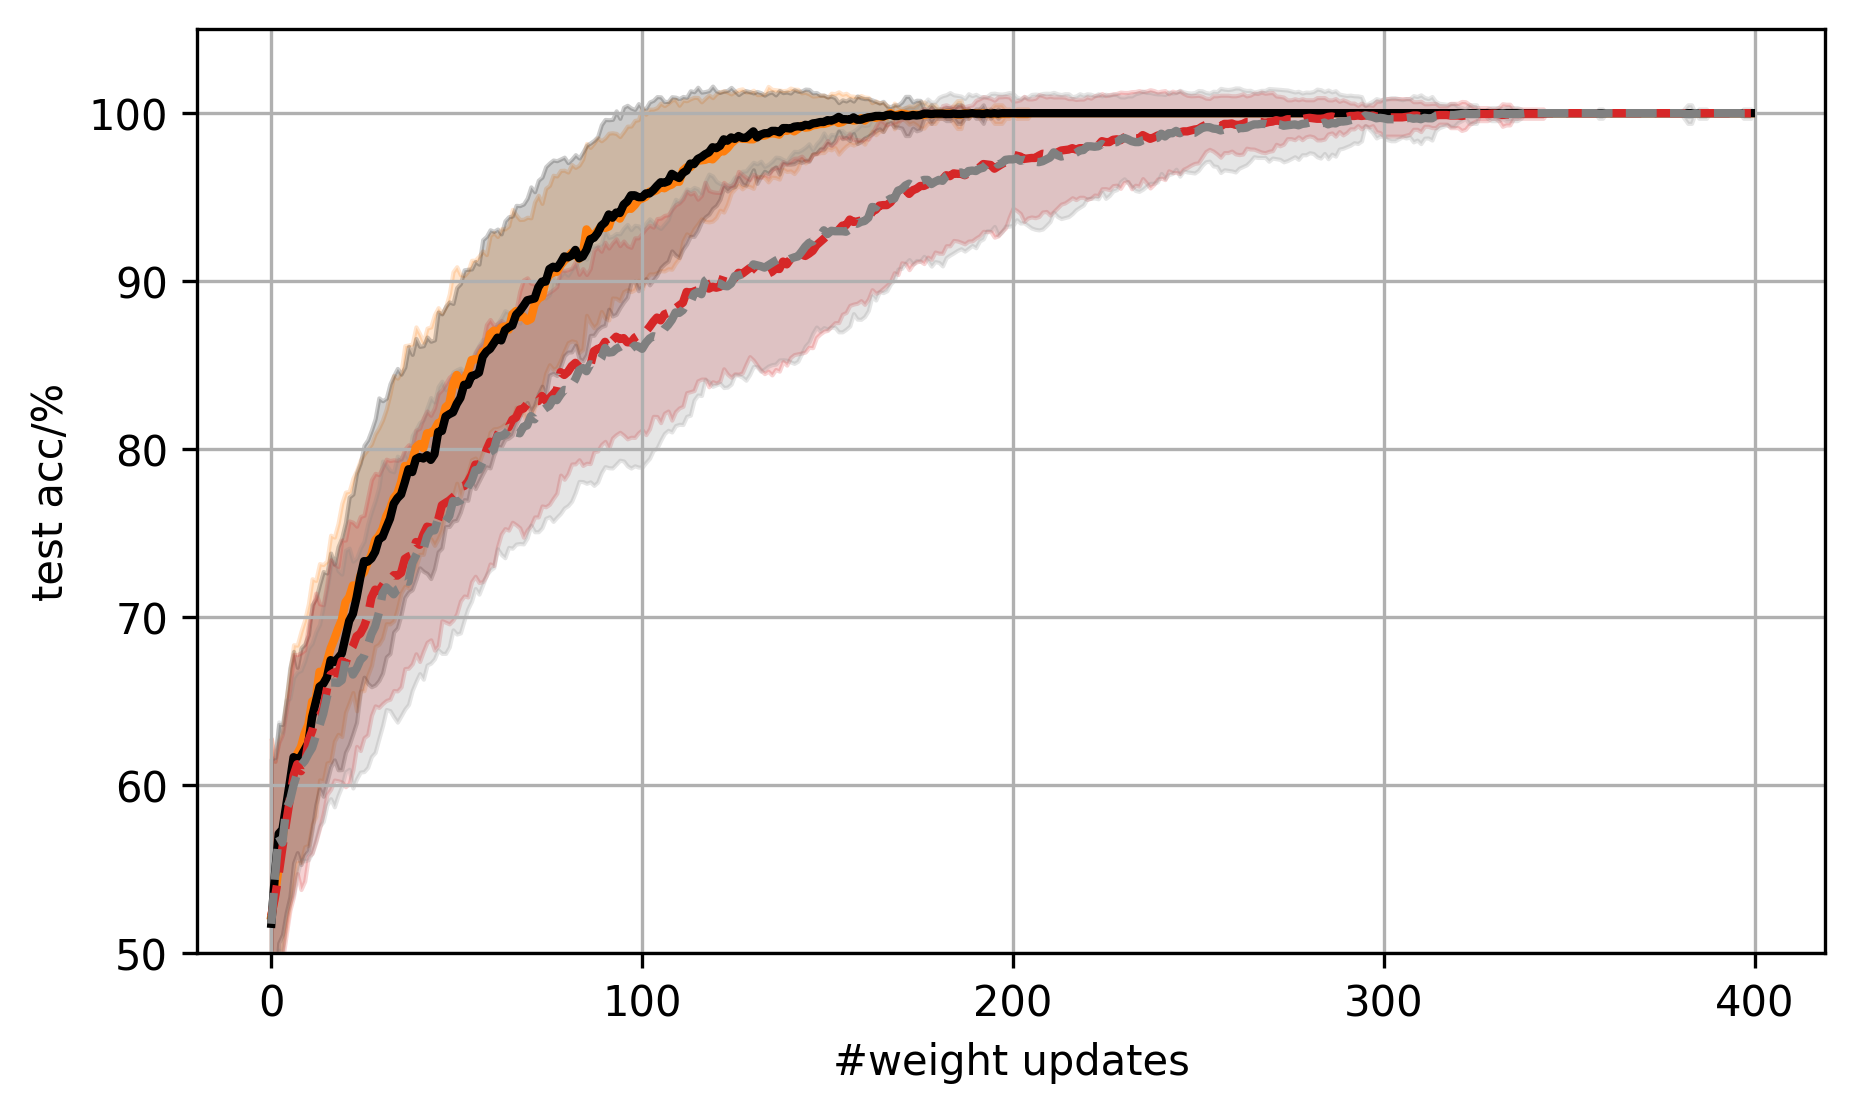

In [9]:
import matplotlib.pyplot as plt
data_array = np.array(all_accuracies)*100
data_array_w = np.array(all_accuracies_w)*100
# Calculate mean and standard deviation across the data
mean_values = np.mean(data_array, axis=0)
std_values = np.std(data_array, axis=0)
mean_values_w = np.mean(data_array_w, axis=0)
std_values_w = np.std(data_array_w, axis=0)

# Create an array for the iteration indices
iterations = np.arange(data_array.shape[1])

# Plot mean with shaded standard deviation
plt.figure(figsize=(3.5*2, 2*2), dpi=300)
data_array2 = np.array(all_accuracies2)*100
data_array_w2 = np.array(all_accuracies_w2)*100

# Calculate mean and standard deviation across the data
mean_values2 = np.mean(data_array2, axis=0)
std_values2 = np.std(data_array2, axis=0)
mean_values_w2 = np.mean(data_array_w2, axis=0)
std_values_w2 = np.std(data_array_w2, axis=0)


# Create an array for the iteration indices
iterations = np.arange(data_array2.shape[1])

# Plot mean with shaded standard deviation


plt.fill_between(iterations, mean_values_w2 - std_values_w2, mean_values_w2 + std_values_w2, color="tab:orange", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values_w2, label="Mean Correlation", color="tab:orange", linewidth=2)



plt.fill_between(iterations, mean_values_w - std_values_w, mean_values_w + std_values_w, color="black", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values_w, label="Mean Correlation", color="black", linewidth=2)

plt.fill_between(iterations, mean_values2 - std_values2, mean_values2 + std_values2, color="tab:red", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values2, linestyle='dashed', label="Mean Correlation", color="tab:red", linewidth=2)

plt.fill_between(iterations, mean_values - std_values, mean_values + std_values, color="gray", alpha=0.2, label="Standard Deviation")
plt.plot(iterations, mean_values, linestyle='dashed', label="Mean Correlation", color="gray", linewidth=2)

# epochs = iterations / 90
# plt.xticks(ticks=iterations[::90].tolist()+[450], labels=np.arange(6).astype(np.int8))
plt.ylim(50,105)
plt.xticks(np.arange(0,401,100))
# Add labels and title
# plt.title("Correlation Change Across Training Iterations")
plt.xlabel("#weight updates")
plt.ylabel("test acc/%")
# plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [10]:
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

num_objects = 10
input_dim = num_objects
hidden_dim = 1000
output_dim = 1

# Ground truth ranking
ground_truth_ranking = range(10)  # Example: 0 < 1 < 2 < 4 < 3

# Create all possible pairs of objects
pairs = [(i, j) for i in range(num_objects) for j in range(num_objects) if i != j]
labels = [(1 if ground_truth_ranking.index(i) < ground_truth_ranking.index(j) else -1) for i, j in pairs]

pairs2 = [(i, i+1) for i in range(num_objects-1)]
labels2 = [1 for i, j in pairs2]
print(pairs2, labels2)
# One-hot encode the input
one_hot_vectors = torch.eye(num_objects)

target_cos = 0#(np.arange(0, 0.1, 0.01))#, np.arange(0.1, 0.6, 0.1)))
all_corr = []
all_corr2 = []
targets = list(np.arange(0, 0.1, 0.01))+list(np.arange(0.1, 0.6, 0.1))

all_number_of_pairs = []
all_number_of_pairs_adj = []
for target_cos in targets:
    print(target_cos)
    number_of_pairs1 = []
    number_of_pairs2 = []
    for repeat in tqdm(range(100),desc='repeat'):
        corr = []
        corr2 = []
        counts = 0
        # Initialize W (fixed, random)
        W = gen_W(num_objects, hidden_dim, target_cos) #torch.randn(hidden_dim, input_dim, requires_grad=False)

        # Initialize P (trainable)
        P = torch.randn(output_dim, hidden_dim, requires_grad=False) * 0.0001

        # Learning rate
        eta = 0.1

        # Number of epochs
        num_epochs = 20
        total_counts = 10000
        num_epochs2 = num_epochs*10

        # Define the error function
        def error_function(v_i, v_j, label):
            error = torch.sign(torch.maximum((label * (v_i - v_j) +1), torch.tensor(0))*label)
            return error

        # Track the mean of v for each object over epochs
        mean_v_values = np.zeros((total_counts, num_objects))
        mean_v_values2 = np.zeros((total_counts, num_objects))
        # Training loop

#         for counts in range(total_counts):
#             epoch_error = 0
#             pairs, labels = shuffle(pairs, labels)
#     #         for (i, j), label in zip(pairs, labels):
#             n = torch.randint(0,90,(1,))
#             i,j = pairs[n]
#             label = labels[n]

#             s_i = W @ one_hot_vectors[i]
#             s_j = W @ one_hot_vectors[j]

#             v_i = P @ s_i
#             v_j = P @ s_j

#             e = error_function(v_i.mean(), v_j.mean(), label)
#             e_vec = torch.full((output_dim,), e.item())

#             with torch.no_grad():
#                 P += eta * torch.outer(e_vec, s_j-s_i) #- 0.0002*torch.sign(P)
#     #             P *= 0.998
#             for i in range(num_objects):
#                 s_i = W @ one_hot_vectors[i]
#                 v_i = P @ s_i
#     #                     print(v_i)
#                 mean_v_values[counts, i] = v_i.mean().item()

#             summed_v_values = mean_v_values[counts, :]
#             learned_ranking = sorted(range(num_objects), key=lambda i: summed_v_values[i])
#             learned1 = np.array(learned_ranking)
#             ground_truth = np.array(ground_truth_ranking)
#             correlation = np.corrcoef(learned1, ground_truth)[0, 1]
#             if learned_ranking == list(ground_truth_ranking):
# #                 print('rand:', counts)
#                 number_of_pairs1.append(counts)
#                 break
#             corr.append(correlation)
#         all_corr+= [corr]
        counts = 0
        P = torch.randn(output_dim, hidden_dim, requires_grad=False) * 0.0001
        for counts in range(total_counts):
            epoch_error = 0
            pairs2, labels2 = shuffle(pairs2, labels2)
    #         for (i, j), label in zip(pairs2, labels2):
            n = torch.randint(0,9,(1,))
            i,j = pairs2[n]
            label = 1
            s_i = W @ one_hot_vectors[i]
            s_j = W @ one_hot_vectors[j]

            v_i = P @ s_i
            v_j = P @ s_j

            e = error_function(v_i.mean(), v_j.mean(), label)
            e_vec = torch.full((output_dim,), e.item())

            with torch.no_grad():
                P += eta * torch.outer(e_vec, s_j-s_i) #- 0.0002*torch.sign(P)
    #             P *= 0.998
            for i in range(num_objects):
                s_i = W @ one_hot_vectors[i]
                v_i = P @ s_i
    #                     print(v_i)
                mean_v_values2[counts, i] = v_i.mean().item()

            summed_v_values2 = mean_v_values2[counts, :]
            learned_ranking = sorted(range(num_objects), key=lambda i: summed_v_values2[i])
            learned2 = np.array(learned_ranking)
            ground_truth = np.array(ground_truth_ranking)

            correlation = np.corrcoef(learned2, ground_truth)[0, 1]
            if learned_ranking == list(ground_truth_ranking):
#                 print('adj:', counts)
                number_of_pairs2.append(counts)
                break
            corr2.append(correlation)
        all_corr2+= [corr2]
    all_number_of_pairs+=[number_of_pairs1]
    all_number_of_pairs_adj += [number_of_pairs2]
    

                    
                    

            # Compute the mean v values for each object


[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9)] [1, 1, 1, 1, 1, 1, 1, 1, 1]
0.0


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.01


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.02


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.03


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.04


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.05


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.06


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.07


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.08


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.09


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.1


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.2


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.30000000000000004


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.4


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

0.5


repeat:   0%|          | 0/100 [00:00<?, ?it/s]

# Figure S1B

/home/yukun/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/yukun/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/yukun/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yukun/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/yukun/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


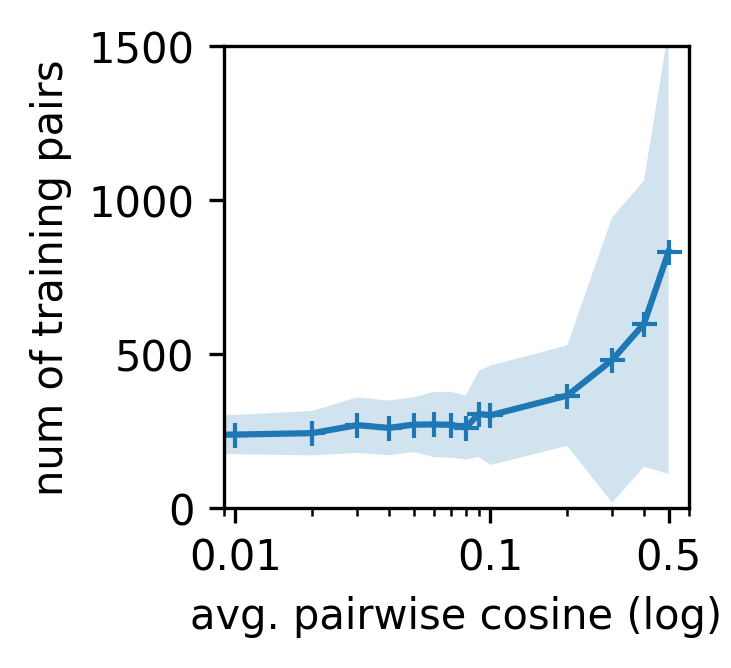

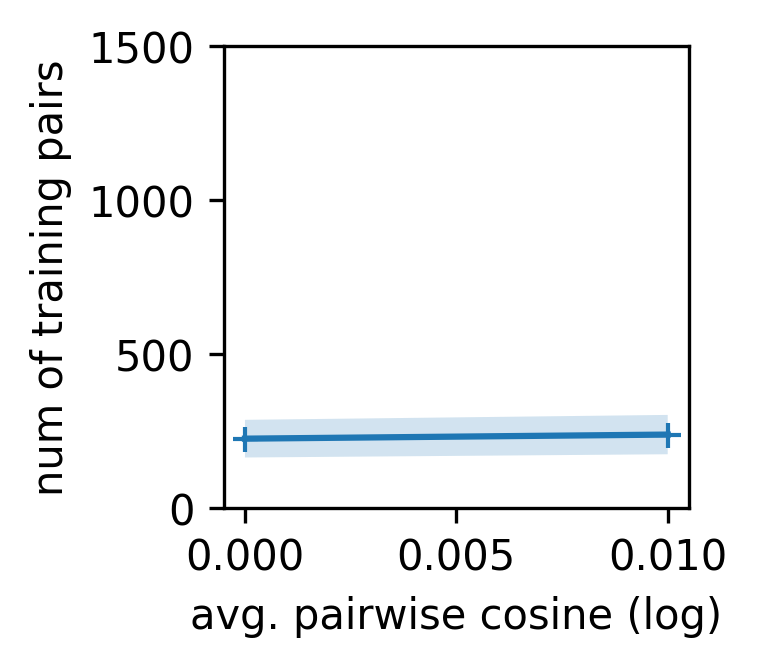

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import ScalarFormatter

# Example data
ranges = 15
all_corrects = np.zeros(15)#np.array(all_number_of_pairs[:ranges]).mean(axis=1)
std_corrects = np.zeros(15)#np.std(np.array(all_number_of_pairs[:ranges]), axis=1)

for i in range(15):
    all_corrects[i] = np.mean(all_number_of_pairs[i])
    std_corrects[i] = np.std(all_number_of_pairs[i])
    
all_corrects_adj = np.zeros(15)#np.array(all_number_of_pairs_adj[:ranges]).mean(axis=1)
std_corrects_adj = np.zeros(15)#np.std(np.array(all_number_of_pairs_adj[:ranges]), axis=1)

for i in range(15):
    all_corrects_adj[i] = np.mean(all_number_of_pairs_adj[i])
    std_corrects_adj[i] = np.std(all_number_of_pairs_adj[i])

# [100,100,100,99.8,99.7,99.4,98.4,97.4,97.4,95.9,95.4,88.2, 80.3,62.5,41.9] 
# all_corrects_adj = [1000, 1000, 999, 999, 996, 998, 997, 996, 996, 994, 993, 986, 958, 892, 739]

plt.figure(figsize=(2, 2), dpi=300)
plt.ylabel('num of training pairs')
plt.xlabel('avg. pairwise cosine (log)')
# plt.plot(targets[:ranges], np.array(all_corrects), marker='+',label='rand')
plt.plot(targets[:ranges], np.array(all_corrects_adj), marker='+',label='adj')

# plt.fill_between(targets[:ranges], all_corrects - std_corrects, all_corrects + std_corrects, alpha=0.2)
plt.fill_between(targets[:ranges], all_corrects_adj - std_corrects_adj, all_corrects_adj + std_corrects_adj, alpha=0.2)

# plt.legend()
# Set x-axis to log scale and format ticks in decimal form
plt.xlim(0.009,0.6)
plt.ylim(0,1500)
plt.xscale('log')
plt.gca().xaxis.set_major_formatter(ScalarFormatter())

def custom_format(x, pos):
    return f"{x:g}"
plt.xticks([0.01, 0.1, 0.5],[custom_format(tick, None) for tick in [0.01, 0.1, 0.5]])

# plt.plot([0.009,0.5],[all_corrects_adj[0],all_corrects_adj[0]], c='red',lw=0.2)

plt.show()


